# Notebook Initialization

In [1]:
from google.colab import drive
from tqdm.auto import tqdm
import os
import shutil
import random
import json
import torch
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

shutil.copy('/content/drive/MyDrive/Thesis/visudo_pc/visudo_scripts.zip', '/content/')
print('The ZIP file was copied.')

shutil.unpack_archive('/content/visudo_scripts.zip', 'visudo_scripts', 'zip')
print('The ZIP file was unpacked.')

os.remove('/content/visudo_scripts.zip')
print('The ZIP file was removed.')

if not os.path.exists('/content/data/'):
    os.makedirs('/content/data/')
    print('The data directory was created.')
else:
    print('The data directory already exists.')

Mounted at /content/drive
The ZIP file was copied.
The ZIP file was unpacked.
The ZIP file was removed.
The data directory was created.


# Data Collection

## Specifications

In [ ]:
SOURCE_MAP = {
    'mnist': lambda label: int(str(label).split('_')[-1]),
    'emnist': lambda label: int(str(label).split('_')[-1]) - 10,
    'kmnist': lambda label: int(str(label).split('_')[-1]),
    'fmnist': lambda label: int(str(label).split('_')[-1])
}
BOARD_DIM = 4
SPLIT_LIST = list(split + 1 for split in range(11))

## Collection

In [ ]:
def main(source_name:str, split:int, verbose:bool) -> None:

    # Initialization
    if verbose:
        print(f'Source: {source_name}, Split: {split}')
    dataset_name = f'{source_name}_{BOARD_DIM}x{BOARD_DIM}_split_{split:02}'
    output_dir = f'/content/data/{dataset_name}'

    # Download
    if verbose:
        print('  Downloading...')
    if not os.path.exists(output_dir):
        !python /content/visudo_scripts/generate-split.py --dataset {source_name} --dimension {BOARD_DIM} --split {split} --out-dir {output_dir} > /dev/null 2>&1

    # Investigation
    if verbose:
        print('  Investigating...')
    current_dir = output_dir
    while True:
        child_list = os.listdir(current_dir)
        if len(child_list) == 1 and child_list[0].endswith(''):
            current_dir = os.path.join(current_dir, child_list[0])
            continue
        break

    # Processing
    if verbose:
        print('  Processing...')
    data_dict = {
        'train': dict[str, torch.Tensor](),
        'val': dict[str, torch.Tensor](),
        'test': dict[str, torch.Tensor]()
    }
    for alias, subset_name in zip(['train', 'valid', 'test'], data_dict):
        with open(os.path.join(current_dir, f'{alias}_puzzle_pixels.txt'), 'r') as text_file:
            symbols = torch.tensor([json.loads('[' + line.replace('\t', ',') + ']') for line in text_file.readlines()])
            data_dict[subset_name]['symbols'] = (symbols.reshape(200, BOARD_DIM, BOARD_DIM, 28, 28) * 255).to(torch.uint8)
        with open(os.path.join(current_dir, f'{alias}_cell_labels.txt'), 'r') as text_file:
            digits = torch.tensor([[SOURCE_MAP[source_name](label) for label in line.strip().split('\t')] for line in text_file.readlines()])
            data_dict[subset_name]['digits'] = digits.reshape(200, BOARD_DIM, BOARD_DIM).to(torch.uint8)
        with open(os.path.join(current_dir, f'{alias}_puzzle_labels.txt'), 'r') as text_file:
            labels = torch.tensor([int(line.strip().split('\t')[0]) for line in text_file.readlines()])
        data_dict[subset_name]['labels'] = labels.to(torch.bool)

    # Storage
    if verbose:
        print('  Storing...')
    dataset_path = f'/content/data/{dataset_name}.pt'
    if os.path.exists(dataset_path):
        os.remove(dataset_path)
    torch.save(data_dict, dataset_path)

    # Cache Removal
    if verbose:
        print('  Removing Cache...')
    shutil.rmtree(output_dir)

In [ ]:
pbar = tqdm(total=len(SOURCE_MAP) * len(SPLIT_LIST), desc='Data Collection')
for source_name in SOURCE_MAP:
    for split in SPLIT_LIST:
        pbar.set_postfix_str(f'Source: {source_name}, Split: {split}')
        main(source_name, split, verbose=False)
        pbar.update(1)
pbar.close()

Data Collection:   0%|          | 0/44 [00:00<?, ?it/s]

## Transfering to Drive

In [ ]:
for file_name in os.listdir('/content/data/'):
    if file_name.endswith('.pt'):
        source_path = os.path.join('/content/data/', file_name)
        destination_path = os.path.join('/content/drive/MyDrive/Thesis/visudo_pc/datasets/', file_name)
        shutil.copy(source_path, destination_path)

## Random Visualization

mnist_4x4_split_06.pt


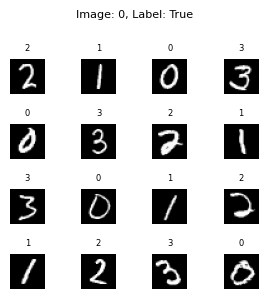

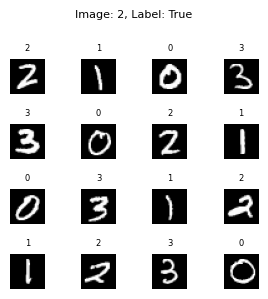

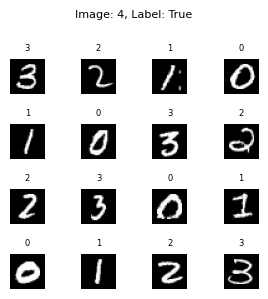

In [ ]:
file_name_name_list = [file_name for file_name in os.listdir('/content/data/') if file_name.endswith('.pt')]
file_name = random.choice(file_name_name_list)
print(file_name)

source_path = os.path.join('/content/data/', file_name)
data_dict[dict[str, torch.Tensor]] = torch.load(os.path.join('/content/data/', file_name))
symbols = data_dict['train']['symbols']
digits = data_dict['train']['digits']
labels = data_dict['train']['labels']
for l in [0, 2, 4]:
    fig, axs = plt.subplots(nrows=BOARD_DIM, ncols=BOARD_DIM, figsize=(3, 3))
    fig.suptitle(f'Image: {l}, Label: {labels[l]}', fontsize=8)
    for i in range(BOARD_DIM):
        for j in range(BOARD_DIM):
            ax:plt.Axes = axs[i, j]
            ax.imshow(symbols[l, i, j, :, :], cmap='gray')
            ax.set_title(f'{digits[l, i, j]}', fontsize=6)
            ax.axis('off')
    fig.tight_layout()